In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import time
import warnings
warnings.filterwarnings("ignore")

In [16]:
data = pd.read_csv('/kaggle/input/finaldata/train.csv')

# Data Problems
**1. Imbalance** - USE SMOTE

**2. Code Gender contain "XNA" value**

**3. DAY_BIRTH negative**

**4. DAY_EMPLOYED contain value > 1000 years**

**5. NaN value**

# Preprocessing

**1. Drop "XNA" value**

In [17]:
data = data[data['CODE_GENDER'] != "XNA"]

**2. DAY_BIRTH**

In [18]:
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

**3. Fill NaN DAY_EMPLOYED contain value > 1000 years**

In [19]:
data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

**4. Handling NaN value**

In [20]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns['Data Type'] = df.dtypes[mis_val_table_ren_columns.index]
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
      
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [21]:
missing_values = missing_values_table(data)
missing_values

Your selected dataframe has 46 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values,Data Type
OWN_CAR_AGE,66017,66.0,float64
EXT_SOURCE_1,56281,56.3,float64
OCCUPATION_TYPE,31223,31.2,object
EXT_SOURCE_3,19827,19.8,float64
DAYS_EMPLOYED,17865,17.9,float64
AMT_REQ_CREDIT_BUREAU_YEAR,13437,13.4,float64
AMT_REQ_CREDIT_BUREAU_MON,13437,13.4,float64
AMT_REQ_CREDIT_BUREAU_HOUR,13437,13.4,float64
AMT_REQ_CREDIT_BUREAU_QRT,13437,13.4,float64
AMT_REQ_CREDIT_BUREAU_WEEK,13437,13.4,float64


**Drop columns which have percentage NaN value >= 50%**

**Fill NaN value for categorical features has % NaN < 2% = mode**

**Fill NaN value for categorical features has % NaN > 2% = "Missing"**

**Fill NaN value for numerical features = mean**

In [22]:
data = data.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1'], axis=1)

In [23]:
nan_nums = ['EXT_SOURCE_3','DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_YEAR',    
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',     
'AMT_REQ_CREDIT_BUREAU_WEEK',  'AMT_REQ_CREDIT_BUREAU_DAY',      
'AMT_REQ_CREDIT_BUREAU_HOUR',  'DEF_60_CNT_SOCIAL_CIRCLE',  
'OBS_30_CNT_SOCIAL_CIRCLE',    'OBS_60_CNT_SOCIAL_CIRCLE',        
'DEF_30_CNT_SOCIAL_CIRCLE',    'EXT_SOURCE_2',                     
'AMT_GOODS_PRICE',   'AMT_ANNUITY',  'DAYS_LAST_PHONE_CHANGE',            
'CNT_FAM_MEMBERS']
for nan_num in nan_nums:
    data[nan_num] = data[nan_num].fillna(data[nan_num].mean())

In [24]:
data['NAME_TYPE_SUITE'].fillna('Missing', inplace=True)
data['OCCUPATION_TYPE'].fillna('Missing', inplace=True)

# MODEL

In [51]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
]

In [52]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    x = time.time()
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        prediction = model.predict_proba(X_test)[:, 1]
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        score_test.append({
            'Classifier': model.__class__.__name__,
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'ROC-AUC': roc_auc_score(y_test, prediction),
            'F1-score': f1,
            'Recall': recall,
            'Precision': precision,
        })

        # Plot ROC-AUC curve for each model
        fpr, tpr, thresholds = roc_curve(y_test, prediction)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic for {names[i]}')
        plt.legend(loc="lower right")
        plt.show()

    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='Accuracy', ascending=False, inplace=True)
    print(score_df)

# Predict Using All Orginal Features

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test 80:20
3. Scale data by MinMax Scaler
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [42]:
data_encode = pd.get_dummies(data)

**Step 2**

In [43]:
data_encode.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637.0,...,False,False,False,False,False,False,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188.0,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038.0,...,False,False,False,False,False,False,False,False,False,False


In [44]:
X = data_encode.drop(['SK_ID_CURR','TARGET'], axis=1)
y = data_encode['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("X=",X_train.shape, X_test.shape)
print("y=",y_train.shape, y_test.shape)

X= (79997, 155) (20000, 155)
y= (79997,) (20000,)


**Step 3**

In [45]:
scaler = MinMaxScaler()

In [46]:
cols = X_train.columns
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

**Step 4**

In [38]:
sm = SMOTE(random_state=42)

In [47]:
X_train,y_train = sm.fit_resample(X_train,y_train)

In [48]:
y_train.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

**Step 5**

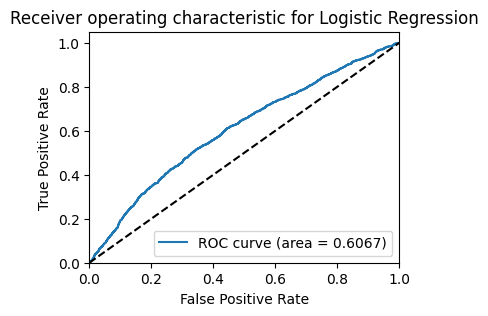

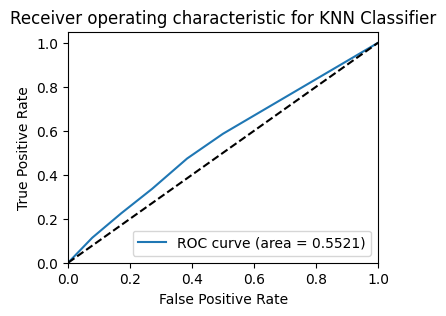

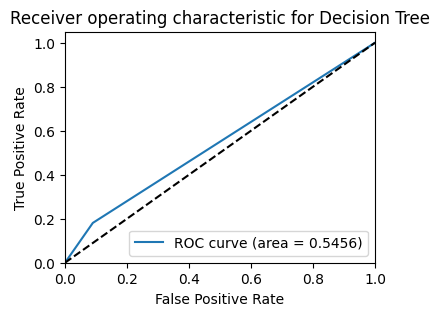

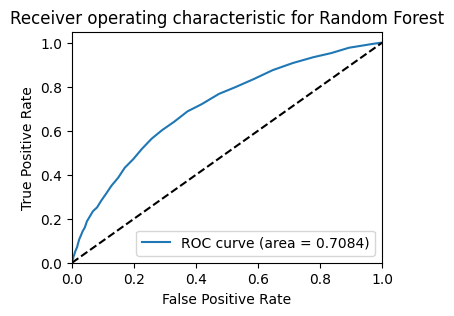

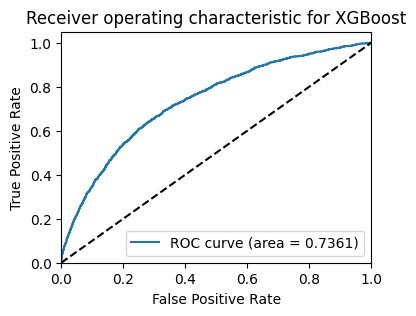

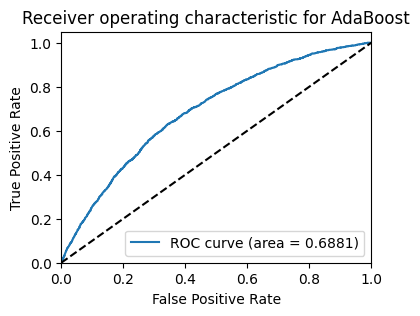

               Classifier  Accuracy   ROC-AUC  F1-score    Recall  Precision
4           XGBClassifier   0.91925  0.736110  0.073437  0.039531   0.516129
3  RandomForestClassifier   0.91920  0.708368  0.006150  0.003088   0.714286
5      AdaBoostClassifier   0.91275  0.688136  0.053174  0.030266   0.218750
2  DecisionTreeClassifier   0.85120  0.545605  0.164514  0.180976   0.150798
1    KNeighborsClassifier   0.69710  0.552077  0.152253  0.336010   0.098426
0      LogisticRegression   0.63030  0.606679  0.187473  0.526868   0.114022


In [41]:
# no scale + smote
score(X_train, X_test, y_train, y_test, names = names, models = models)

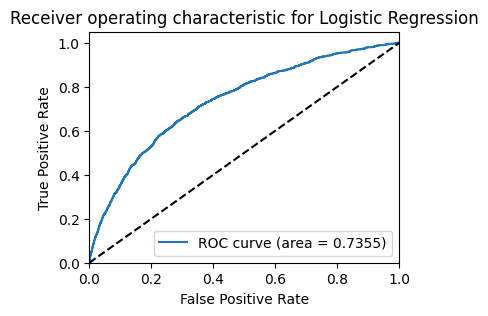

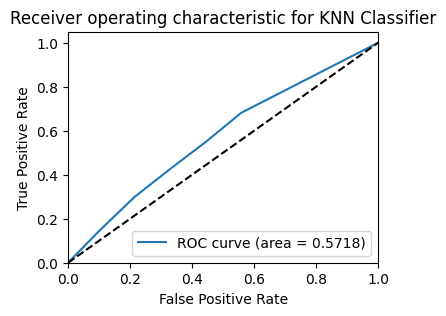

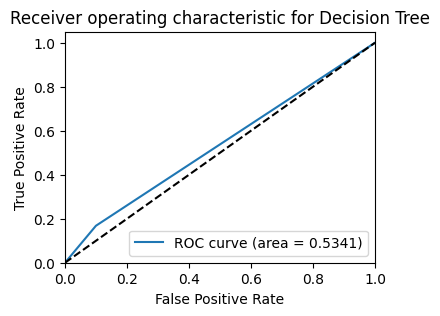

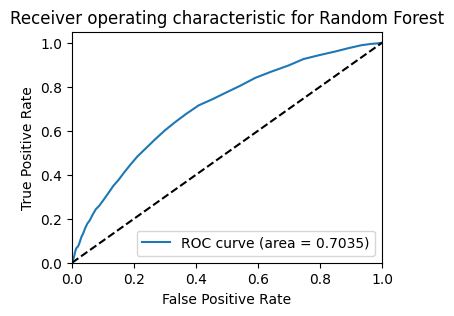

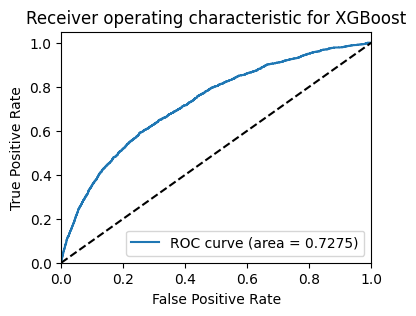

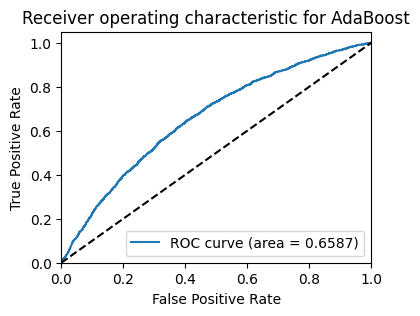

               Classifier  Accuracy   ROC-AUC  F1-score    Recall  Precision
3  RandomForestClassifier   0.91800  0.703454  0.016787  0.008647   0.285714
4           XGBClassifier   0.91745  0.727526  0.062465  0.033972   0.387324
5      AdaBoostClassifier   0.86535  0.658684  0.163924  0.163064   0.164794
2  DecisionTreeClassifier   0.84095  0.534114  0.146040  0.168005   0.129155
0      LogisticRegression   0.68800  0.735471  0.256966  0.666461   0.159168
1    KNeighborsClassifier   0.65050  0.571849  0.165074  0.426807   0.102325


In [53]:
# minmax +smote
score(X_train, X_test, y_train, y_test, names = names, models = models)

# Predict by Feature Selection using WOE

1. Calculate WoE for each features
2. Calculate IV
3. Drop feature has IV < 0.02
4. Predict ML in remain original feature

In [54]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
    

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(data, target='TARGET', bins=20)

Information value of SK_ID_CURR is 0.001356
Information value of NAME_CONTRACT_TYPE is 0.013637
Information value of CODE_GENDER is 0.039292
Information value of FLAG_OWN_CAR is 0.005493
Information value of FLAG_OWN_REALTY is 0.000208
Information value of CNT_CHILDREN is 0.001106
Information value of AMT_INCOME_TOTAL is 0.013409
Information value of AMT_CREDIT is 0.064915
Information value of AMT_ANNUITY is 0.036477
Information value of AMT_GOODS_PRICE is 0.108772
Information value of NAME_TYPE_SUITE is 0.00201
Information value of NAME_INCOME_TYPE is 0.056264
Information value of NAME_EDUCATION_TYPE is 0.052831
Information value of NAME_FAMILY_STATUS is 0.026742
Information value of NAME_HOUSING_TYPE is 0.014373
Information value of REGION_POPULATION_RELATIVE is 0.052624
Information value of DAYS_BIRTH is 0.085016
Information value of DAYS_EMPLOYED is 0.103264
Information value of DAYS_REGISTRATION is 0.026532
Information value of DAYS_ID_PUBLISH is 0.039589
Information value of FLAG

**DROP IV < 0.02**

In [55]:
low_IV_cols =  ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
      'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_HOUR',   
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',   'AMT_REQ_CREDIT_BUREAU_WEEK']

In [63]:
data_woe = data.drop(low_IV_cols, axis = 1)

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test with different size 70:30, 80:20
3. Scale data by MinMax Scaler
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [64]:
data_encode = pd.get_dummies(data_woe)

**Step 2**

In [65]:

Xw = data_encode.drop(['TARGET'], axis=1)
yw = data_encode['TARGET']

X_trainw, X_testw, y_trainw, y_testw = train_test_split(Xw, yw, test_size=0.2, stratify=yw, random_state=42)

print("X=",X_trainw.shape, X_testw.shape)
print("y=",y_trainw.shape, y_testw.shape)

X= (79997, 113) (20000, 113)
y= (79997,) (20000,)


**Step 3**

In [66]:
scaler = MinMaxScaler()

In [67]:
cols = X_trainw.columns
X_trainw[cols] = scaler.fit_transform(X_trainw[cols])
X_testw[cols] = scaler.transform(X_testw[cols])

**Step 4**

In [68]:
sm = SMOTE(random_state=42)

In [69]:
X_trainw,y_trainw = sm.fit_resample(X_trainw,y_trainw)

**Step 5**

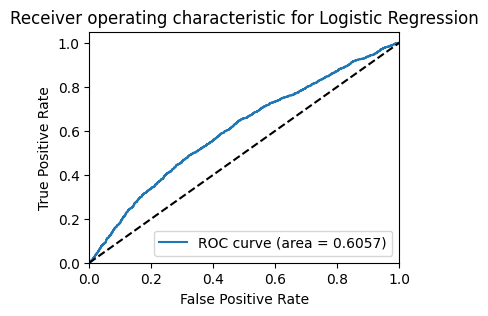

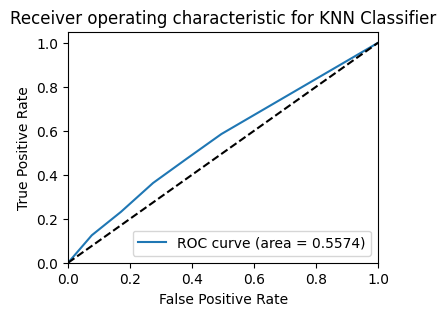

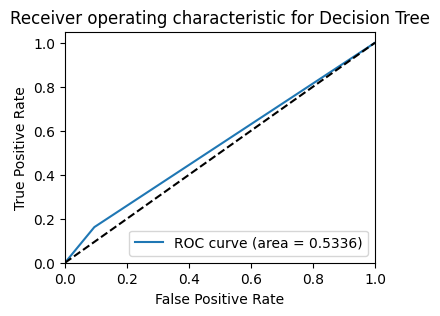

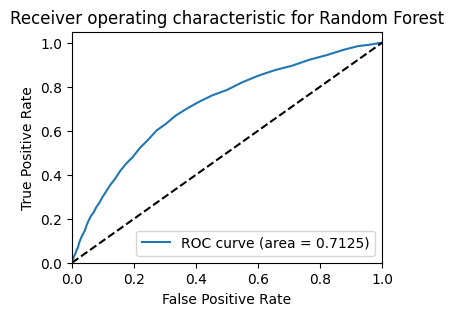

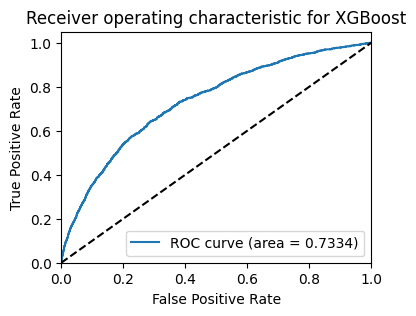

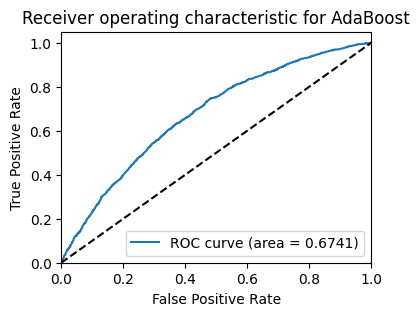

               Classifier  Accuracy   ROC-AUC  F1-score    Recall  Precision
4           XGBClassifier   0.91845  0.733446  0.052295  0.027795   0.441176
3  RandomForestClassifier   0.91740  0.712462  0.028235  0.014824   0.296296
5      AdaBoostClassifier   0.89780  0.674077  0.111304  0.079061   0.187959
2  DecisionTreeClassifier   0.84520  0.533610  0.144751  0.161828   0.130935
1    KNeighborsClassifier   0.69650  0.557424  0.162065  0.362569   0.104356
0      LogisticRegression   0.61085  0.605703  0.183402  0.539839   0.110465


In [62]:
# noscale + smote
score(X_trainw, X_testw, y_trainw, y_testw, names = names, models = models)

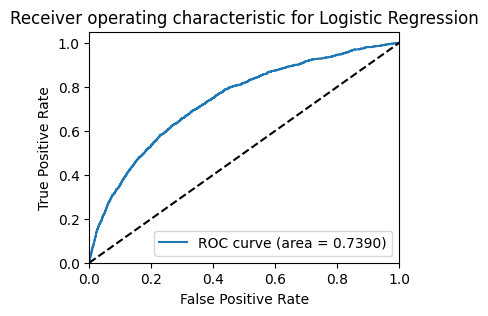

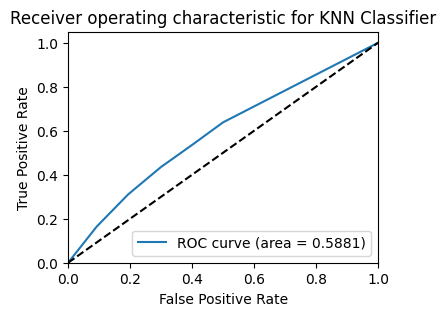

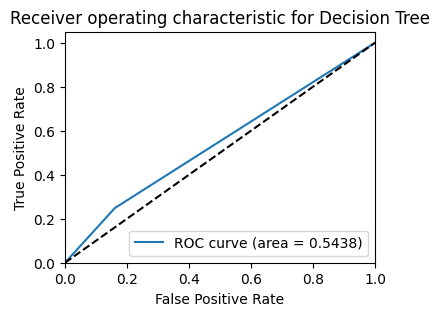

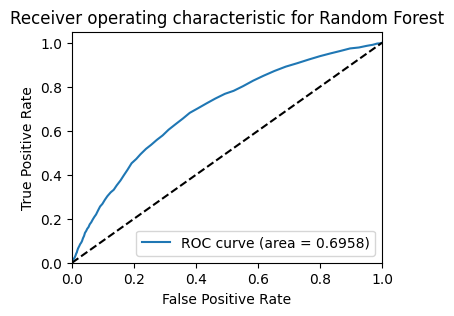

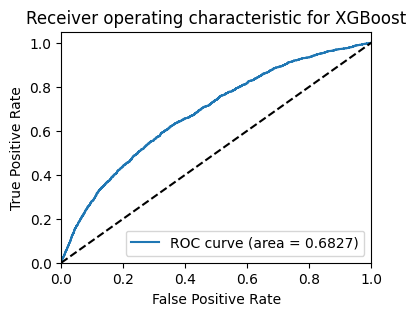

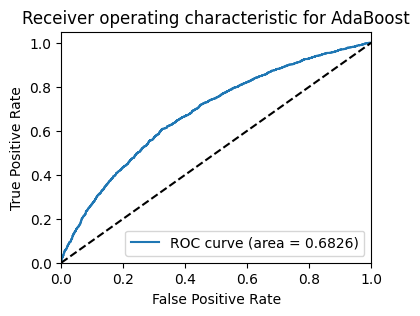

               Classifier  Accuracy   ROC-AUC  F1-score    Recall  Precision
4           XGBClassifier   0.89320  0.682658  0.176561  0.141445   0.234872
3  RandomForestClassifier   0.88900  0.695766  0.173492  0.143916   0.218369
2  DecisionTreeClassifier   0.79150  0.543823  0.161641  0.248301   0.119821
5      AdaBoostClassifier   0.78020  0.682611  0.235478  0.418159   0.163883
0      LogisticRegression   0.68655  0.739045  0.256435  0.667696   0.158691
1    KNeighborsClassifier   0.67910  0.588136  0.179913  0.434836   0.113420


In [70]:
# minmax + smote
score(X_trainw, X_testw, y_trainw, y_testw, names = names, models = models)